<a href="https://colab.research.google.com/github/ajoshiusc/deep_grp_reg/blob/main/mnist_register.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import torch
import monai
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from monai.networks.nets import unet
from monai.networks.blocks import Warp
from monai.config import USE_COMPILED
from tqdm import tqdm
from torch.nn import MSELoss
import numpy as np


In [45]:
from tensorflow.keras.datasets import mnist


(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

fixed = np.float32(x_train[3])
moving = np.float32(x_train[4])

fixed = resize(fixed,(64,64))
moving = resize(moving,(64,64))


shape of x_train: (5421, 28, 28), y_train: (5421,)


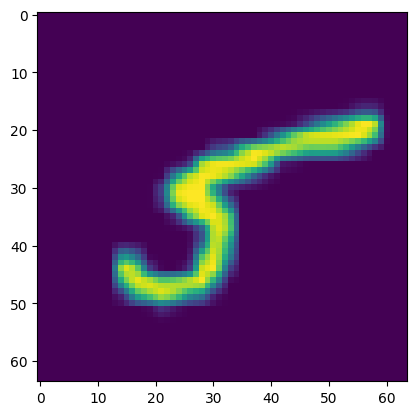

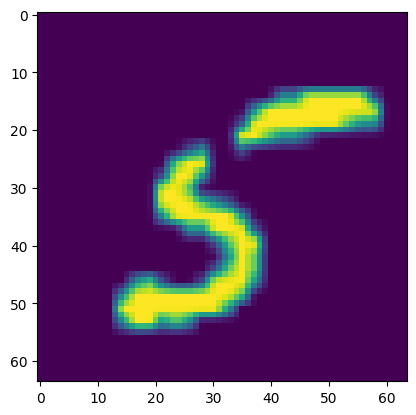

In [46]:
plt.imshow(moving)
plt.show()
plt.imshow(fixed)


Create registration network

In [47]:
reg = unet.UNet(spatial_dims=2,  # spatial dims
    in_channels=2,
    out_channels=2,# output channels (to represent 2D displacement vector field)
    channels=(16, 32, 32, 32, 32),  # channel sequence
    strides=(1, 2, 2, 4),  # convolutional strides
    dropout=0.2,
    norm="batch").to('cuda')

if USE_COMPILED:
    warp_layer = Warp(2, padding_mode="zeros").to('cuda')
else:
    warp_layer = Warp("bilinear", padding_mode="zeros").to('cuda')


reg.train()
optimizerR = torch.optim.Adam(reg.parameters(), lr=0.001)


In [48]:
image_loss = MSELoss() 
regularization_loss = BendingEnergyLoss()
image_loss.to('cuda')

MSELoss()

In [49]:
input_data = torch.cat((torch.tensor(moving[None,]), torch.tensor(fixed[None,])), dim=0)
input_data = input_data[None, ].to('cuda')

max_epochs = 1000

moving = torch.tensor(moving[None,None,]).to('cuda')
fixed = torch.tensor(fixed[None,None,]).to('cuda')

for epoch in tqdm(range(max_epochs)):

    optimizerR.zero_grad()
    ddf = reg(input_data)
    moved = warp_layer(moving, ddf)

    imgloss = image_loss(moved, fixed) + 10*regularization_loss(ddf)

    imgloss.backward()
    optimizerR.step()





100%|██████████| 1000/1000 [00:14<00:00, 66.84it/s]


In [50]:


print(10000*regularization_loss(ddf))
print(image_loss(moved, fixed))

tensor(21987.8008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(122.8588, device='cuda:0', grad_fn=<MseLossBackward0>)


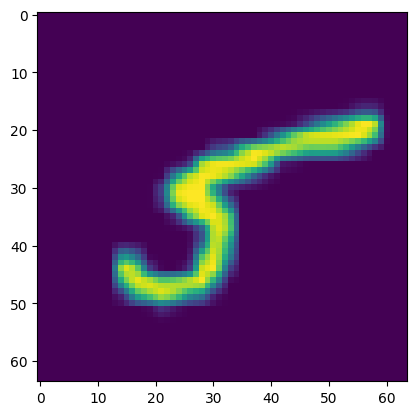

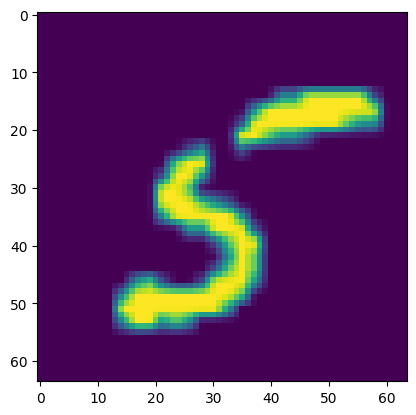

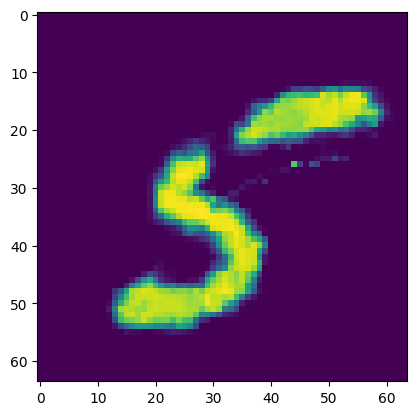

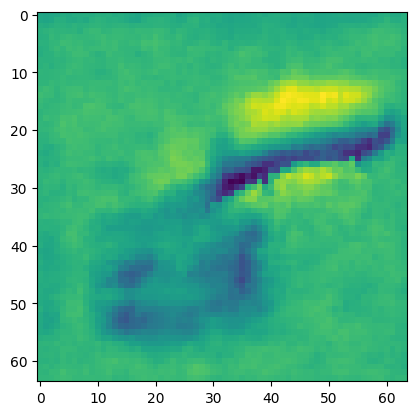

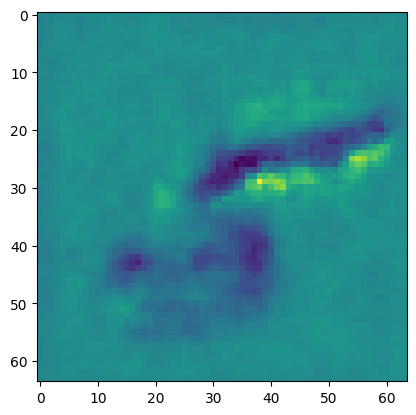

In [51]:
plt.imshow(moving[0,0].to('cpu').numpy())
plt.show()
plt.imshow(fixed[0,0].to('cpu').numpy())
plt.show()
plt.imshow(moved[0,0].detach().to('cpu').numpy())
plt.show()
plt.imshow(ddf[0,0].detach().to('cpu').numpy())
plt.show()
plt.imshow(ddf[0,1].detach().to('cpu').numpy())
